1. Set up libraries and load data

1.1 import libraries

In [1]:
import seaborn as sns              # Data visualization library, supports beautiful plotting
import matplotlib.pyplot as plt    # Basic plotting library in Python
from sklearn.model_selection import train_test_split  # Function to split data into train/test sets
from sklearn.preprocessing import OneHotEncoder       # Encode categorical variables as numbers (one-hot)
from sklearn.compose import ColumnTransformer         # Utility to process multiple variable types (numeric, categorical) at once
from sklearn.pipeline import Pipeline                 # Build a pipeline of sequential processing steps
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Decision tree model and tree plotting function
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Model evaluation functions
from pathlib import Path                             # Manage file/folder paths in the file system

1.2 Load the dataset

In [2]:
penguins = sns.load_dataset("penguins")      # 344 mẫu – 3 lớp
penguins.dropna(inplace=True)                # bỏ 2 % dòng bị khuyết

II. Preparing the datasets

2.1 Identify features & labels

In [3]:
features = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','sex']
X = penguins[features]
y = penguins['species']                      # Adelie, Chinstrap, Gentoo

2.2 One-hot encoding for the variable sex (categorical)

In [4]:
categorical = ['sex']
numeric     = list(set(features) - set(categorical))
preprocess  = ColumnTransformer(
      [("cat", OneHotEncoder(), categorical),
       ("num", "passthrough", numeric)]
)

2.3 Create 4 train/test pairs with ratios 40/60, 60/40, 80/20, 90/10, then shuffle and stratify

In [5]:
splits = {}
for train_size in [0.4, 0.6, 0.8, 0.9]:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=42, shuffle=True)
    key = f"{round(train_size*100)}/{round((1-train_size)*100)}"
    splits[key] = (X_tr, X_te, y_tr, y_te)

2.4 Display class distribution

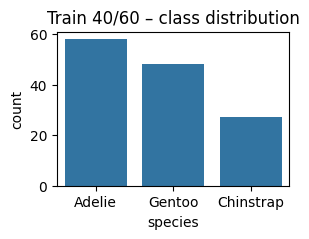

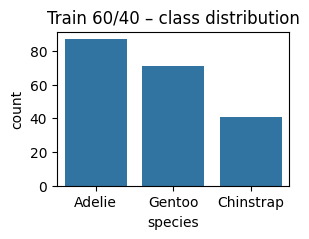

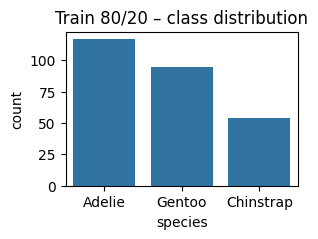

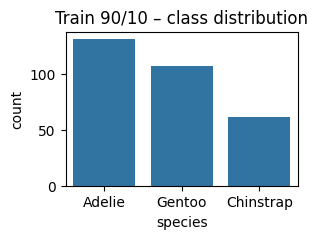

In [6]:
for name,(X_tr, X_te, y_tr, y_te) in splits.items():
    plt.figure(figsize=(3,2))
    sns.countplot(x=y_tr, order=y.value_counts().index)
    plt.title(f"Train {name} – class distribution")
    plt.show()

3. Training & Visualizing Decision Tree (Building the classifiers)

In [7]:
Path("figures").mkdir(exist_ok=True)    # create root folder

for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    clf = Pipeline([
        ("prep", preprocess),
        ("dt",  DecisionTreeClassifier(criterion="entropy", random_state=42))
    ]).fit(X_tr, y_tr)

    plt.figure(figsize=(16, 10))
    plot_tree(
        clf.named_steps["dt"],
        feature_names=clf.named_steps["prep"].get_feature_names_out(),
        class_names=clf.named_steps["dt"].classes_,
        filled=True, rounded=True, proportion=True
    )
    plt.tight_layout()

    # --- save image ---
    safe_name = name.replace("/", "-")              # avoid path error
    plt.savefig(f"figures/tree_penguins_{safe_name}.png", dpi=300)
    plt.close()

print("✅ Decision trees have been saved to the figures folder")


✅ Decision trees have been saved to the figures folder


4. Model Evaluation (Evaluating the classifiers)


### 40/60 split ###
              precision    recall  f1-score   support

      Adelie      0.953     0.932     0.943        88
   Chinstrap      0.864     0.927     0.894        41
      Gentoo      1.000     0.986     0.993        71

    accuracy                          0.950       200
   macro avg      0.939     0.948     0.943       200
weighted avg      0.952     0.950     0.950       200



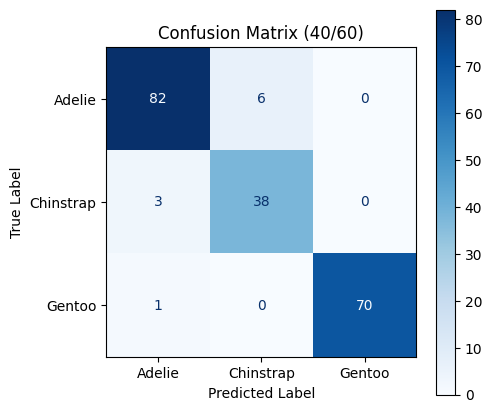


### 60/40 split ###
              precision    recall  f1-score   support

      Adelie      1.000     0.983     0.991        59
   Chinstrap      0.900     1.000     0.947        27
      Gentoo      1.000     0.958     0.979        48

    accuracy                          0.978       134
   macro avg      0.967     0.980     0.973       134
weighted avg      0.980     0.978     0.978       134



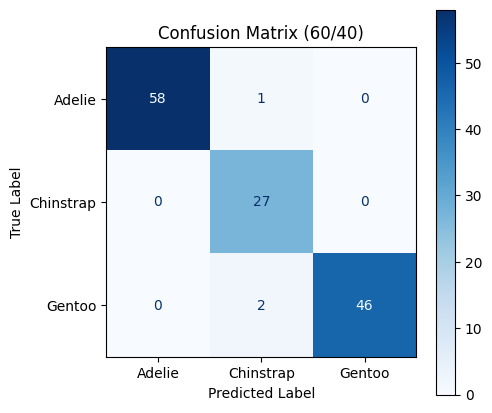


### 80/20 split ###
              precision    recall  f1-score   support

      Adelie      0.966     0.966     0.966        29
   Chinstrap      0.875     1.000     0.933        14
      Gentoo      1.000     0.917     0.957        24

    accuracy                          0.955        67
   macro avg      0.947     0.961     0.952        67
weighted avg      0.959     0.955     0.956        67



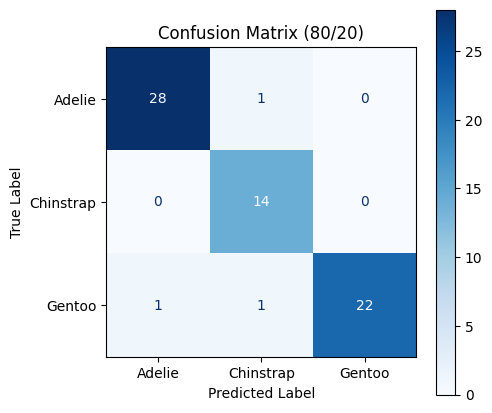


### 90/10 split ###
              precision    recall  f1-score   support

      Adelie      1.000     0.933     0.966        15
   Chinstrap      0.700     1.000     0.824         7
      Gentoo      1.000     0.833     0.909        12

    accuracy                          0.912        34
   macro avg      0.900     0.922     0.899        34
weighted avg      0.938     0.912     0.916        34



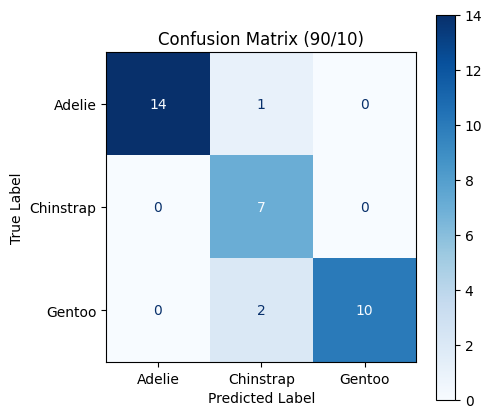

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Train and store models for each split
models = {}
for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    clf = Pipeline([
        ("prep", preprocess),
        ("dt", DecisionTreeClassifier(criterion="entropy", random_state=42))
    ]).fit(X_tr, y_tr)
    models[name] = (clf, X_te, y_te)

import matplotlib.pyplot as plt

for name, (clf, X_te, y_te) in models.items():
    # 1) In báo cáo
    y_pred = clf.predict(X_te)
    print(f"\n### {name} split ###")
    print(classification_report(y_te, y_pred, digits=3))

    # 2) Tính ma trận nhầm lẫn (số)
    cm = confusion_matrix(y_te, y_pred)

    # 3) Vẽ heat-map confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"Confusion Matrix ({name})")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()


5. Effect of Tree Depth (Depth vs Accuracy – 80/20)

✅ Saved tree images to the fig_depth/ folder


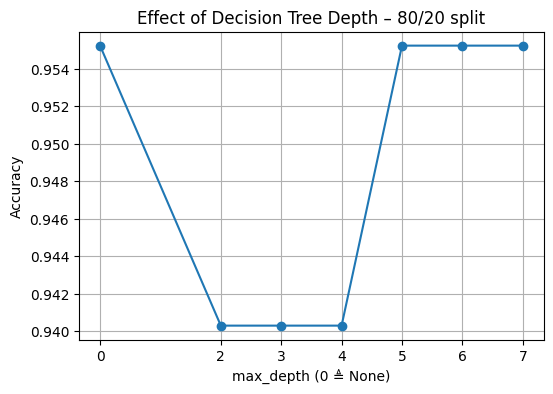

In [9]:
# ❶ Get the correct 80/20 split
X_tr, X_te, y_tr, y_te = splits["80/20"]

# ❷ Try different max_depth values
depths = [None, 2, 3, 4, 5, 6, 7]
acc = []

# ❸ Create a folder to save images
Path("fig_depth").mkdir(exist_ok=True)

for d in depths:
    clf = Pipeline([
        ("prep", preprocess),
        ("dt",  DecisionTreeClassifier(
                    criterion="entropy",
                    max_depth=d,
                    random_state=42))
    ]).fit(X_tr, y_tr)

    # Accuracy
    y_pred = clf.predict(X_te)
    acc.append(accuracy_score(y_te, y_pred))

    # Plot the tree using matplotlib
    plt.figure(figsize=(16, 10))
    plot_tree(
        clf.named_steps["dt"],
        feature_names=clf.named_steps["prep"].get_feature_names_out(),
        class_names=clf.named_steps["dt"].classes_,
        filled=True, rounded=True, proportion=True
    )
    plt.tight_layout()

    depth_tag = d if d is not None else "None"
    plt.savefig(f"fig_depth/tree_depth_{depth_tag}.png", dpi=300)
    plt.close()

print("✅ Saved tree images to the fig_depth/ folder")

# ❹ Plot depth vs Accuracy chart
plt.figure(figsize=(6,4))
plt.plot([0 if d is None else d for d in depths], acc, marker="o")
plt.xticks([0]+depths[1:])
plt.xlabel("max_depth (0 ≜ None)")
plt.ylabel("Accuracy")
plt.title("Effect of Decision Tree Depth – 80/20 split")
plt.grid(True)
plt.savefig("fig_depth/depth_vs_accuracy.png", dpi=300)
plt.show()